# Graph-based Pattern Representations Tutorial





## Framework

<img src="./img/0_framework.png" width="600" align="left">

---
### Jupyter notebook setting

In [1]:
%load_ext autoreload
%autoreload 2

class display_df(object):
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

---
## Load data

In [2]:
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_colwidth', 100)

data_path_sub = './data/train.pkl'
pattern_dir = './pattern_dir'

text_col = 'text'
label_col = 'emotion'

if not os.path.isdir(pattern_dir):
    os.mkdir(pattern_dir)

df_train = pd.read_pickle(data_path_sub)
col_list = [label_col, text_col]
df_train = df_train[col_list]

df_train.head()

,emotion,text
1704,fear,@realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?' #Tr...
1152,fear,We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...
1038,fear,@twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...
3497,sadness,#PeopleLikeMeBecause of some unknown reason but I try to discourage it
1940,fear,@BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake


## Preprocessing

Finish all the preprocessing tasks here (e.g. splite sentence, tokenize, replace something...)

In [3]:
import nltk
import patternlib.utils as utils

tokenizer = nltk.tokenize.TweetTokenizer()

# preprocessing function
def my_preprocess(text):
    text = utils.tweet_replaceToken(text)
    text = tokenizer.tokenize(text)
    return text

df_train['tokenized_text'] = df_train[text_col].apply(lambda text: my_preprocess(text))

df_train.head()

,emotion,text,tokenized_text
1704,fear,@realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?' #Tr...,"[<M>, <M>, new, campaign, slogan, idea, ..., ', i, know, you, are, but, what, am, i, ?, ', <H>, ..."
1152,fear,We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...,"[we, in, our, own, country, are, so, divided, in, our, approach, so, how, could, we, fight, <H>,..."
1038,fear,@twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...,"[<M>, <M>, <M>, <M>, <M>, <M>, <M>, oh, god, ,, not, brewer, again, ., the, horror, ,, the, horror]"
3497,sadness,#PeopleLikeMeBecause of some unknown reason but I try to discourage it,"[<H>, of, some, unknown, reason, but, i, try, to, discourage, it]"
1940,fear,@BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake,"[<M>, awe, i'm, sorry, !, i, have, 2, dogs, 3, cats, &, a, snake]"


---
## 1. Graph construction

<img src="./img/1_GC.png" width="860">        
<br>

Using the neighbor frequency between tokens in all texts to construct a undirected weighted graph, as:

<img src="./img/1_eq.png" width="200">       

construct: `graph_utils.ngramGraph()`    
visualize: `graph_utils.show_graph()`

#### Note:
1. The weight and normalize methods are user-defined.
2. The graph operation of our `graph_utils` library is based on `networkx` python library ([https://github.com/networkx/networkx](https://github.com/networkx/networkx)).   
    There is another efficient graph software `Gephi` ([https://gephi.org/](https://gephi.org/)) you can try.
    

In [4]:
import patternlib.graph_utils as graph_utils

# input form: array or list
textlist_train = df_train['tokenized_text'].values

# construct graph
graph_sub = graph_utils.ngramGraph(textlist=textlist_train, gram_n=2, 
                                   space_token='_space_', max_norm=True, 
                                   take_ratio=1.0, freq_threshold=3)


Graph constructed from (3613) texts, there are (1012) nodes in this graph.


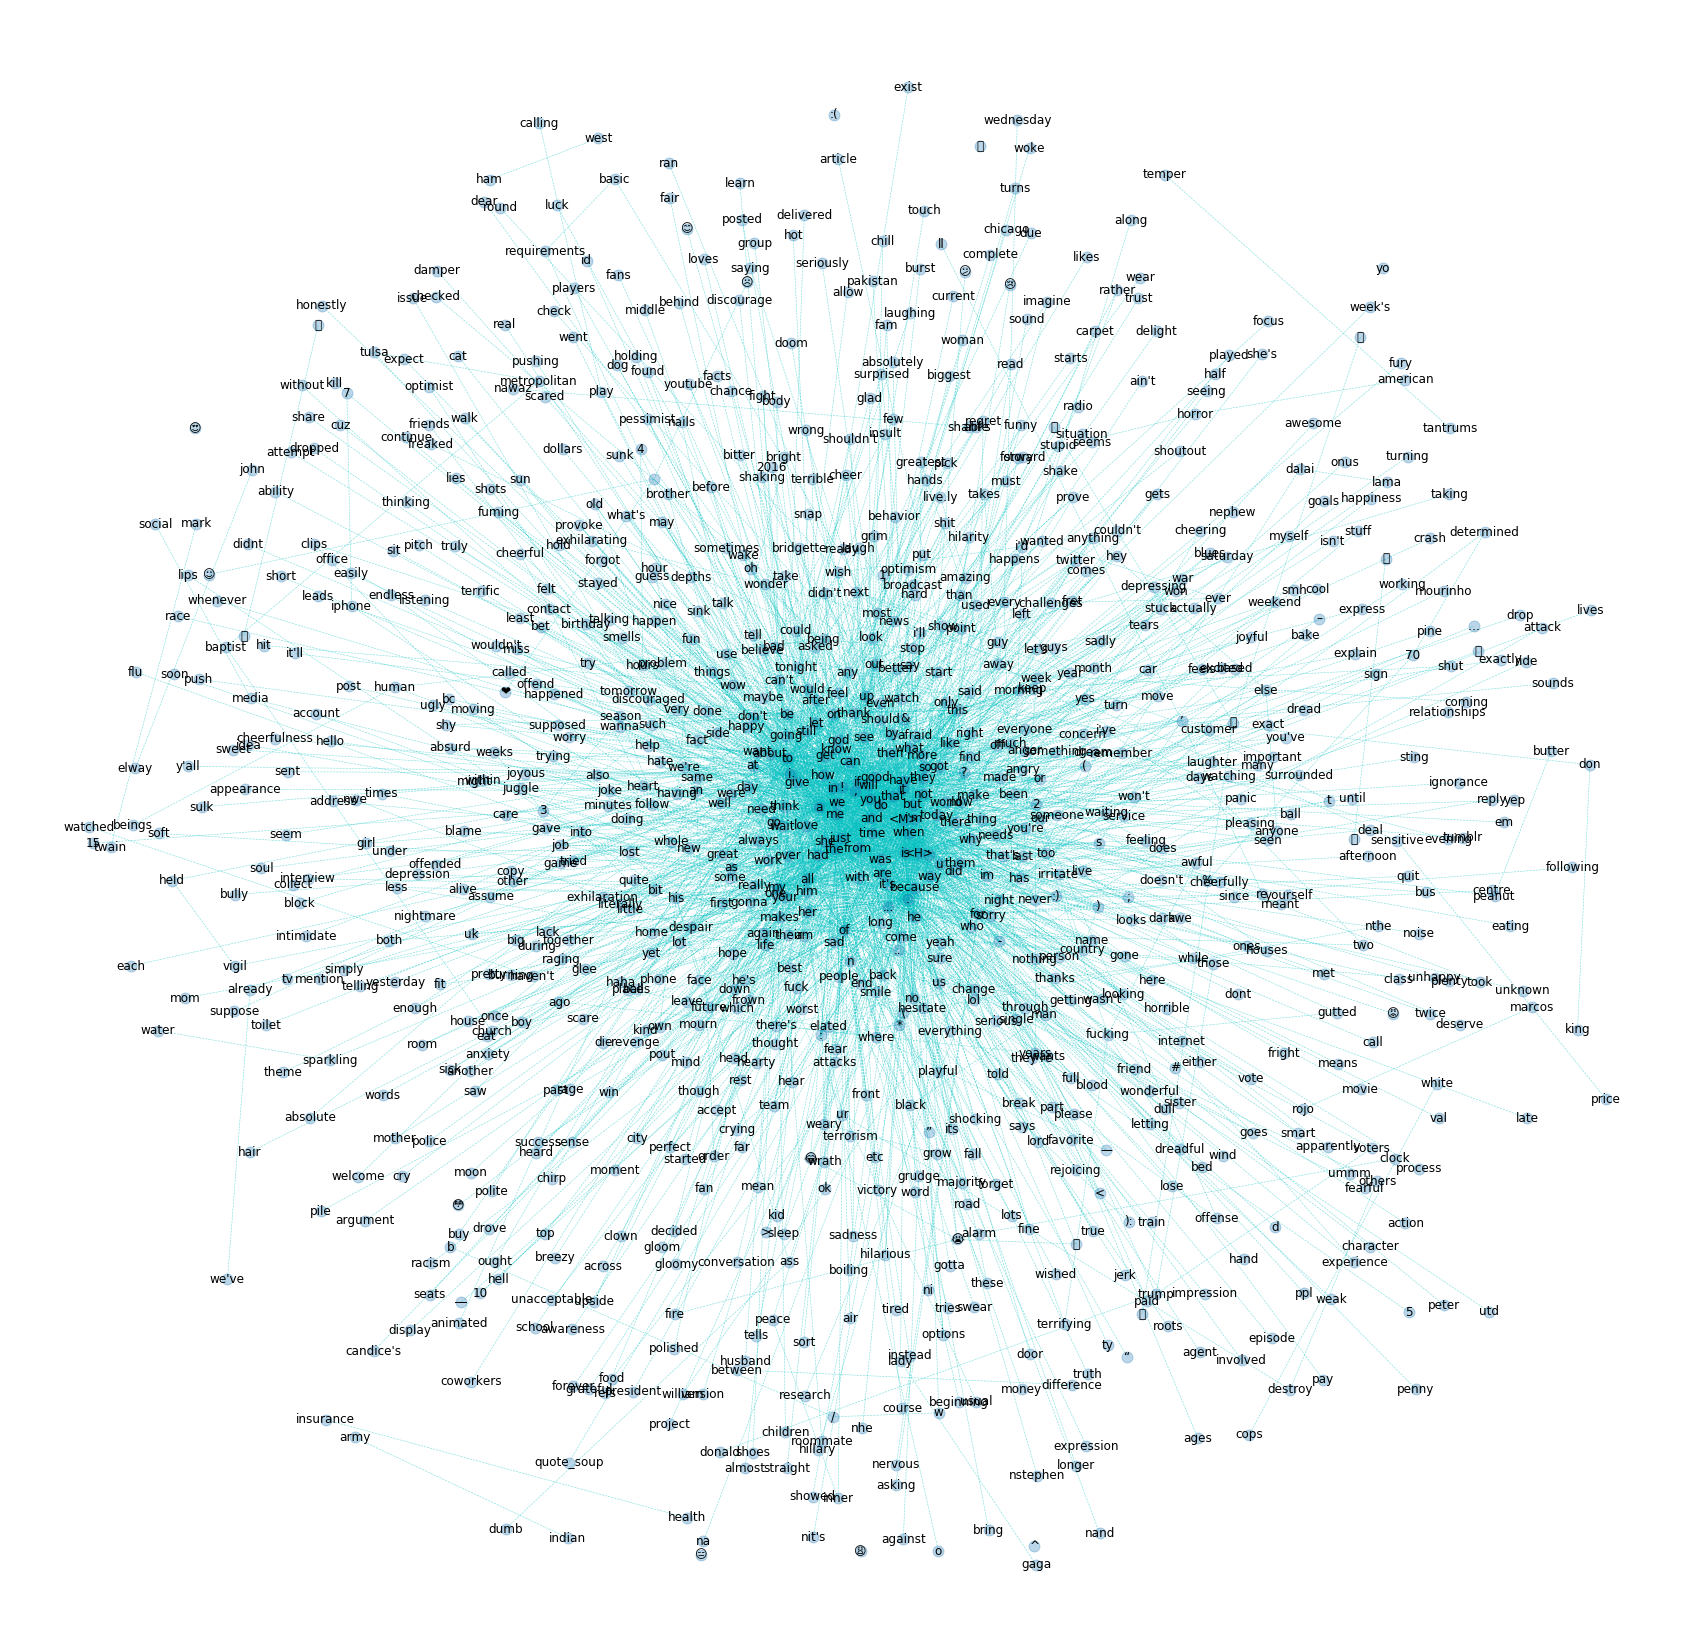

In [5]:
# graph visualization
graph_utils.show_graph(graph_sub)

Here I skip the `graph aggregation` part (graph_emo = graph_sub - graph_obj), it can be operated by `graph_utils.graph_minus()`

In [6]:
# graph_emo = graph_utils.graph_minus(graph_sub, graph_obj)

# Using the same graph to extract patterns.
graph_emo = graph_sub

---
## 2. Token Categorization (CW, SW)

<br>
<img src="./img/2_TC.png" width="860">

Determine the `Connector words` and `Subject words` by `eigenvector centrality` and `clustering coeffcient` respectively.     
(by `graph_utils.graph_calculate()`)

In [7]:
# input: graph
df_ec, df_cc = graph_utils.graph_calculate(graph_emo)

print('eigenvector centrality, clustering coeffcient')
display_df('df_ec.head(10)', 'df_cc.head(10)')

eigenvector centrality, clustering coeffcient


,token,value
2,.,0.256876
0,<H>,0.220464
1,<M>,0.220352
8,the,0.219438
15,",",0.204645
32,a,0.176779
10,to,0.171002
25,is,0.155121
6,i,0.153902
61,that,0.152587


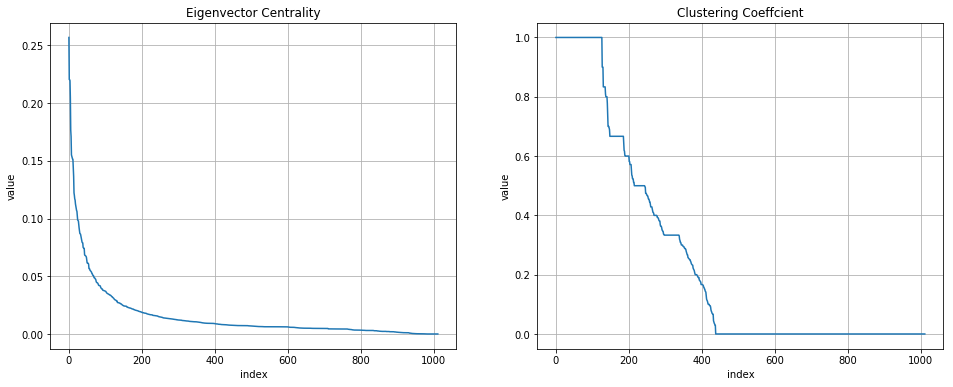

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualization
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(df_ec['value'].values)
plt.title('Eigenvector Centrality')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cc['value'].values)
plt.title('Clustering Coeffcient')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.show()

### decide the threshold for CW & SW
User-definded threshold (`threshold_ec`, `threshold_cc`)

In [9]:
# ec for CW, cc for SW
threshold_ec = 0.025
threshold_cc = 0.3333

In [10]:
# hint: using frequency to help us decide `threshold_cc`.
df_cc['value'].value_counts().head(8)

0.000000    574
1.000000    127
0.333333     41
0.666667     38
0.500000     29
0.600000     11
0.400000      8
0.833333      6
Name: value, dtype: int64

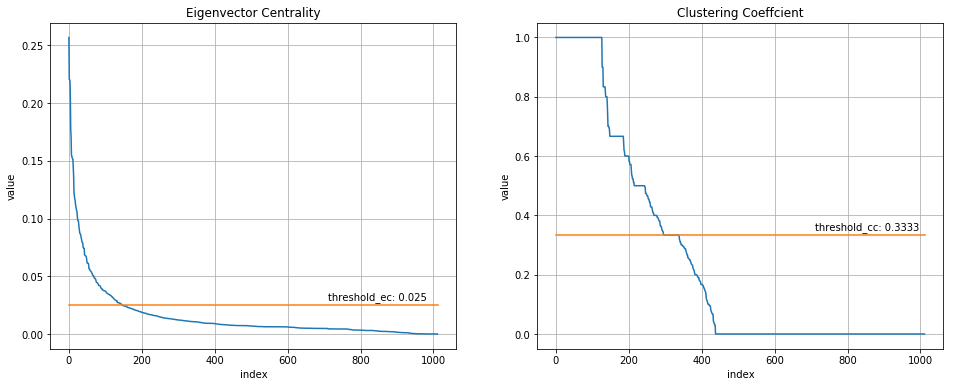

In [11]:
# visualize again
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(df_ec['value'].values)
plt.plot([0, len(df_ec)], [threshold_ec, threshold_ec], linestyle='solid')
plt.text(len(df_ec)-300, threshold_ec+0.005, 'threshold_ec: {}'.format(threshold_ec))
plt.title('Eigenvector Centrality')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cc['value'].values)
plt.plot([0, len(df_cc)], [threshold_cc, threshold_cc], linestyle='solid')
plt.text(len(df_cc)-300, threshold_cc+0.02, 'threshold_cc: {}'.format(threshold_cc))
plt.title('Clustering Coeffcient')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.show()

### Obtain CW list & SW list

Based on the thresholds, we obtain the `CW_list` and `SW_list`. (by `utils.token2CWSWlist()`)

In [12]:
import patternlib.utils as utils

CW_list = utils.token2CWSWlist(df=df_ec, threshold=threshold_ec)
SW_list = utils.token2CWSWlist(df=df_cc, threshold=threshold_cc)

print('CW_list: ', CW_list[:8], ' ...')
print('SW_list: ', SW_list[:8], ' ...')

CW_list:  ['.' '<H>' '<M>' 'the' ',' 'a' 'to' 'is']  ...
SW_list:  ['mourn' 'horrible' '):' 'within' "he's" 'which' 'happened' 'blood']  ...


In [13]:
# save
cw_file = os.path.join(pattern_dir, 'CW_list.npy')
sw_file = os.path.join(pattern_dir, 'SW_list.npy')

np.save(cw_file, CW_list)
np.save(sw_file, SW_list)
print('save ok\n {}\n {}'.format(cw_file, sw_file))

# load
# CW_list = np.load(cw_file)
# SW_list = np.load(sw_file)

save ok
 ./pattern_dir/CW_list.npy
 ./pattern_dir/SW_list.npy


---
## 3. Pattern extraction
<br>
<img src="./img/3_PE.png" width="860">

### convert tokens to CW SW

Convert `tokenized_text` column into cwsw type. (by apply `cwsw_utils.token2cwsw()`)

In [14]:
import patternlib.cwsw_utils as cwsw_utils

df_train['cwsw_text'] = df_train['tokenized_text'].apply(lambda text:
                        cwsw_utils.token2cwsw(tokens=text, cw_list=CW_list, sw_list=SW_list, 
                                              cw_token='cw', sw_token='sw', none_token='_', both_token='both'))
df_train.head()

,emotion,text,tokenized_text,cwsw_text
1704,fear,@realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?' #Tr...,"[<M>, <M>, new, campaign, slogan, idea, ..., ', i, know, you, are, but, what, am, i, ?, ', <H>, ...","[cw, cw, sw, _, _, _, both, both, cw, cw, cw, cw, both, cw, sw, cw, cw, both, cw, cw, cw]"
1152,fear,We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...,"[we, in, our, own, country, are, so, divided, in, our, approach, so, how, could, we, fight, <H>,...","[cw, cw, cw, _, _, cw, cw, _, cw, cw, _, cw, cw, _, cw, _, cw, cw, cw, sw, cw]"
1038,fear,@twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...,"[<M>, <M>, <M>, <M>, <M>, <M>, <M>, oh, god, ,, not, brewer, again, ., the, horror, ,, the, horror]","[cw, cw, cw, cw, cw, cw, cw, sw, both, cw, cw, _, sw, cw, cw, _, cw, cw, _]"
3497,sadness,#PeopleLikeMeBecause of some unknown reason but I try to discourage it,"[<H>, of, some, unknown, reason, but, i, try, to, discourage, it]","[cw, cw, both, _, _, both, cw, _, cw, _, cw]"
1940,fear,@BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake,"[<M>, awe, i'm, sorry, !, i, have, 2, dogs, 3, cats, &, a, snake]","[cw, _, cw, sw, cw, cw, cw, _, _, _, _, both, cw, _]"


### build pattern dictionary

Based on pre-definded `pattern_templates` and the label of this dataset to construct pattern dictionary. (by `cwsw_utils.build_patternDict()`)    

#### Note:
1. Here we provide an argument `n_jobs` to decide multi-processing or single-processing. (default `n_jobs=-1`: using all CPU cores)
2. The rule of patterns is defined in `cwsw_utils.build_patternDict_()`.

In [15]:
# user-defined pattern templates
pattern_templates = [['cw', 'sw'], 
                     ['cw', 'cw', 'sw']]

# for check the labels
label_list = list(np.sort(np.unique(df_train[label_col].values)))
print('label_list: ', label_list)

# build pattern-dictionary
pattern_dict = cwsw_utils.build_patternDict(df=df_train, label_list=label_list, 
                                            pattern_templates=pattern_templates, n_jobs=-1)


label_list:  ['anger', 'fear', 'joy', 'sadness']


In [16]:
# check results
for i, key in enumerate(pattern_dict.keys()):
    show = [val for val in (pattern_dict[key].keys()) if val != 'diversity']
    print("'pattern': ", key)
    for inkey in show:
        print("'{}': {}".format(inkey, pattern_dict[key][inkey]), end="\t")
    print()
    print("'diversity': {} ...\n".format([' '.join(tok) for tok in pattern_dict[key]['diversity'][:5]]))
    if i > 5: break

'pattern':  <M> *
'template': cw sw	'anger': 58	'fear': 61	'joy': 55	'sadness': 48	
'diversity': ['<M> new', '<M> snap', '<M> oh', '<M> take', '<M> oh'] ...

'pattern':  what *
'template': cw sw	'anger': 6	'fear': 7	'joy': 6	'sadness': 3	
'diversity': ['what am', "what he's", 'what point', 'what point', 'what happened'] ...

'pattern':  have *
'template': cw sw	'anger': 6	'fear': 6	'joy': 8	'sadness': 11	
'diversity': ['have won', 'have nothing', 'have serious', 'have done', 'have yet'] ...

'pattern':  <M> <M> *
'template': cw cw sw	'anger': 23	'fear': 19	'joy': 12	'sadness': 9	
'diversity': ['<M> <M> new', '<M> <M> oh', '<M> <M> take', '<M> <M> oh', '<M> <M> hilarity'] ...

'pattern':  should have *
'template': cw cw sw	'anger': 2	'fear': 0	'joy': 0	'sadness': 1	
'diversity': ['should have won', 'should have lost', 'should have won'] ...

'pattern':  <H> *
'template': cw sw	'anger': 14	'fear': 27	'joy': 9	'sadness': 14	
'diversity': ['<H> terrorism', '<H> ;', '<H> ;', '<H> ..', '<H> 

### pattern dict -> pattern DataFrame

Convert to `pd.DataFrame` is convenient for operate, visualize, save, load. (by `cwsw_utils.build_patternDF()`)

In [17]:
df_pattern = cwsw_utils.build_patternDF(pattern_dict, label_list)

df_pattern_file = os.path.join(pattern_dir, 'df_pattern.pkl')
df_train_file = os.path.join(pattern_dir, 'df_train_dealed.pkl')

# save
df_pattern.to_pickle(df_pattern_file)
df_train.to_pickle(df_train_file)
print('save ok \n {}\n {}'.format(df_pattern_file, df_train_file))

# load
# df_pattern = pd.read_pickle(df_pattern_file)

df_pattern.head(20)

save ok 
 ./pattern_dir/df_pattern.pkl
 ./pattern_dir/df_train_dealed.pkl


,pattern,template,anger,fear,joy,sadness,diversity
0,<M> *,cw sw,58,61,55,48,"[(<M>, new), (<M>, snap), (<M>, oh), (<M>, take), (<M>, oh), (<M>, oh), (<M>, kind), (<M>, <), (..."
1,what *,cw sw,6,7,6,3,"[(what, am), (what, he's), (what, point), (what, point), (what, happened), (what, kind), (what, ..."
2,have *,cw sw,6,6,8,11,"[(have, won), (have, nothing), (have, serious), (have, done), (have, yet), (have, thought), (hav..."
3,<M> <M> *,cw cw sw,23,19,12,9,"[(<M>, <M>, new), (<M>, <M>, oh), (<M>, <M>, take), (<M>, <M>, oh), (<M>, <M>, hilarity), (<M>, ..."
4,should have *,cw cw sw,2,0,0,1,"[(should, have, won), (should, have, lost), (should, have, won)]"
5,<H> *,cw sw,14,27,9,14,"[(<H>, terrorism), (<H>, ;), (<H>, ;), (<H>, ..), (<H>, fan), (<H>, 😂), (<H>, together), (<H>, w..."
6,a *,cw sw,68,73,65,64,"[(a, problem), (a, fan), (a, guy), (a, customer), (a, dream), (a, very), (a, bit), (a, weary), (..."
7,and <H> *,cw cw sw,1,1,0,1,"[(and, <H>, terrorism), (and, <H>, morning), (and, <H>, 🙄)]"
8,be a *,cw cw sw,1,2,3,0,"[(be, a, problem), (be, a, fun), (be, a, place), (be, a, fun), (be, a, place), (be, a, little)]"
9,and *,cw sw,15,24,33,27,"[(and, hearty), (and, awful), (and, break), (and, break), (and, here), (and, bridgette), (and, b..."


---
## 4. Next step

After pattern extraction, pattern opinion could substitute for word/token opinion on text.   
It means you can design your pattern feature extraction algorithm (e.g. bag-of-patterns, pattern embedding, ...) and apply on your dataset.
